In [5]:
! pip install chardet

# Get and Prepare The Data

In [9]:
import chardet

rawdata = open('bundesliga_results.csv', 'rb').read()
result = chardet.detect(rawdata)
charenc = result['encoding']
print(charenc)

ISO-8859-1


In [65]:
import pandas as pd

data = pd.read_csv('bundesliga_results.csv', encoding='ISO-8859-1')
data = data.drop('Unnamed: 0', axis=1)
print(data.shape)
data.head()

(306, 4)


,Home,HomeGoals,AwayGoals,Away
0,M'Gladbach,1.0,1.0,Bayern Munich
1,Augsburg,0.0,4.0,Hoffenheim
2,Union Berlin,1.0,1.0,Leverkusen
3,Wolfsburg,1.0,0.0,Bochum
4,Arminia,0.0,0.0,Freiburg


In [66]:
data = data.dropna()
print(data.shape)
data.head()

(108, 4)


,Home,HomeGoals,AwayGoals,Away
0,M'Gladbach,1.0,1.0,Bayern Munich
1,Augsburg,0.0,4.0,Hoffenheim
2,Union Berlin,1.0,1.0,Leverkusen
3,Wolfsburg,1.0,0.0,Bochum
4,Arminia,0.0,0.0,Freiburg


# Encode The Team Names

In [67]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data.Home)
print(le.classes_)
print()
print(le.transform(data.Home[:10]))
print(le.inverse_transform(le.transform(data.Home[:10])))

['Arminia' 'Augsburg' 'Bayern Munich' 'Bochum' 'Dortmund' 'Eint Frankfurt'
 'Freiburg' 'Greuther Fürth' 'Hertha BSC' 'Hoffenheim' 'Köln' 'Leverkusen'
 "M'Gladbach" 'Mainz 05' 'RB Leipzig' 'Stuttgart' 'Union Berlin'
 'Wolfsburg']

[12  1 16 17  0 15  4 13 10 14]
["M'Gladbach" 'Augsburg' 'Union Berlin' 'Wolfsburg' 'Arminia' 'Stuttgart'
 'Dortmund' 'Mainz 05' 'Köln' 'RB Leipzig']


In [68]:
data['home_encoded'] = le.transform(data.Home)
data['away_encoded'] = le.transform(data.Away)

data.head()

,Home,HomeGoals,AwayGoals,Away,home_encoded,away_encoded
0,M'Gladbach,1.0,1.0,Bayern Munich,12,2
1,Augsburg,0.0,4.0,Hoffenheim,1,9
2,Union Berlin,1.0,1.0,Leverkusen,16,11
3,Wolfsburg,1.0,0.0,Bochum,17,3
4,Arminia,0.0,0.0,Freiburg,0,6


In [36]:
num_matches = pd.concat([data.Home, data.Away]).reset_index(drop=True)
num_matches.columns = ['Team']
num_matches.value_counts()

M'Gladbach        12
Augsburg          12
Hoffenheim        12
Leverkusen        12
Bochum            12
Freiburg          12
Eint Frankfurt    12
Hertha BSC        12
Greuther Fürth    12
RB Leipzig        12
Köln              12
Mainz 05          12
Dortmund          12
Stuttgart         12
Arminia           12
Wolfsburg         12
Union Berlin      12
Bayern Munich     12
dtype: int64

# Get The Matrix M

In [43]:
import numpy as np

M = np.zeros((18, 18))

for i in range(M.shape[0]):
    M[i, i] = 12
    
for j, row in data.iterrows():
    M[row.home_encoded, row.away_encoded] = -1
    M[row.away_encoded, row.home_encoded] = -1

M

array([[12., -1.,  0.,  0., -1., -1., -1., -1.,  0., -1.,  0., -1., -1.,
        -1.,  0., -1., -1., -1.],
       [-1., 12., -1.,  0., -1., -1., -1.,  0.,  0., -1.,  0., -1., -1.,
        -1.,  0., -1., -1., -1.],
       [ 0., -1., 12., -1.,  0., -1., -1., -1., -1., -1., -1., -1., -1.,
         0., -1.,  0., -1.,  0.],
       [ 0.,  0., -1., 12.,  0., -1.,  0., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.,  0., -1.],
       [-1., -1.,  0.,  0., 12., -1., -1.,  0.,  0., -1., -1., -1., -1.,
        -1., -1., -1., -1.,  0.],
       [-1., -1., -1., -1., -1., 12., -1., -1., -1.,  0., -1.,  0.,  0.,
         0., -1., -1.,  0., -1.],
       [-1., -1., -1.,  0., -1., -1., 12., -1., -1.,  0., -1.,  0.,  0.,
        -1., -1., -1.,  0., -1.],
       [-1.,  0., -1., -1.,  0., -1., -1., 12., -1.,  0., -1.,  0., -1.,
        -1., -1., -1.,  0., -1.],
       [ 0.,  0., -1., -1.,  0., -1., -1., -1., 12., -1., -1., -1., -1.,
         0., -1.,  0., -1., -1.],
       [-1., -1., -1., -1., -1.,  0.,

# Get The Goal Differences (y)

In [69]:
data['home_diff'] = data.HomeGoals - data.AwayGoals
data['away_diff'] = data.AwayGoals - data.HomeGoals

data.head()

,Home,HomeGoals,AwayGoals,Away,home_encoded,away_encoded,home_diff,away_diff
0,M'Gladbach,1.0,1.0,Bayern Munich,12,2,0.0,0.0
1,Augsburg,0.0,4.0,Hoffenheim,1,9,-4.0,4.0
2,Union Berlin,1.0,1.0,Leverkusen,16,11,0.0,0.0
3,Wolfsburg,1.0,0.0,Bochum,17,3,1.0,-1.0
4,Arminia,0.0,0.0,Freiburg,0,6,0.0,0.0


In [70]:
home = pd.DataFrame()
home['team'] = data['Home']
home['goal_diff'] = data['home_diff']

away = pd.DataFrame()
away['team'] = data['Away']
away['goal_diff'] = data['away_diff']

goal_diff = pd.concat([home, away], axis=0).groupby('team').sum().reset_index()
goal_diff

,team,goal_diff
0,Arminia,-9.0
1,Augsburg,-10.0
2,Bayern Munich,28.0
3,Bochum,-9.0
4,Dortmund,12.0
5,Eint Frankfurt,-2.0
6,Freiburg,7.0
7,Greuther Fürth,-25.0
8,Hertha BSC,-14.0
9,Hoffenheim,4.0


# Solve the equation

In [84]:
# Take the X and y
M = M
P = goal_diff.goal_diff

# Make an adjustment
M[17, :] = 1
P[17] = 0

print(M)
print()
print(P)

[[12. -1.  0.  0. -1. -1. -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1. -1.]
 [-1. 12. -1.  0. -1. -1. -1.  0.  0. -1.  0. -1. -1. -1.  0. -1. -1. -1.]
 [ 0. -1. 12. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1.  0. -1.  0.]
 [ 0.  0. -1. 12.  0. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1.]
 [-1. -1.  0.  0. 12. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. 12. -1. -1. -1.  0. -1.  0.  0.  0. -1. -1.  0. -1.]
 [-1. -1. -1.  0. -1. -1. 12. -1. -1.  0. -1.  0.  0. -1. -1. -1.  0. -1.]
 [-1.  0. -1. -1.  0. -1. -1. 12. -1.  0. -1.  0. -1. -1. -1. -1.  0. -1.]
 [ 0.  0. -1. -1.  0. -1. -1. -1. 12. -1. -1. -1. -1.  0. -1.  0. -1. -1.]
 [-1. -1. -1. -1. -1.  0.  0.  0. -1. 12. -1.  0.  0. -1. -1. -1. -1. -1.]
 [ 0.  0. -1. -1. -1. -1. -1. -1. -1. -1. 12. -1.  0. -1. -1.  0. -1.  0.]
 [-1. -1. -1. -1. -1.  0.  0.  0. -1.  0. -1. 12. -1. -1.  0. -1. -1. -1.]
 [-1. -1. -1. -1. -1.  0.  0. -1. -1.  0.  0. -1. 12. -1.  0. -1. -1. -1.]
 [-1. -1.  0. -1. -1.  0.

C:\Users\IRFANA~1\AppData\Local\Temp/ipykernel_7608/738978873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P[17] = 0


In [76]:
for i, j in zip(le.classes_, np.linalg.solve(X, y)):
    print(i, j)

Arminia -0.7767503597081822
Augsburg -0.5277988653874511
Bayern Munich 2.1674438597130115
Bochum -0.7338196111330668
Dortmund 1.0691614384310635
Eint Frankfurt -0.2914963505659658
Freiburg 0.4805486107216974
Greuther Fürth -2.068925566456495
Hertha BSC -1.0399448814336192
Hoffenheim 0.39063997960187513
Köln -0.08119403962815061
Leverkusen 0.669535690616207
M'Gladbach 0.13201788086018093
Mainz 05 0.3027648856065511
RB Leipzig 0.7852693486881929
Stuttgart -0.5480936403049333
Union Berlin 0.2944941206727415
Wolfsburg -0.22385250029365633


In [85]:
np.linalg.solve(M, P)

array([-0.77675036, -0.52779887,  2.16744386, -0.73381961,  1.06916144,
       -0.29149635,  0.48054861, -2.06892557, -1.03994488,  0.39063998,
       -0.08119404,  0.66953569,  0.13201788,  0.30276489,  0.78526935,
       -0.54809364,  0.29449412, -0.2238525 ])

In [81]:
results = pd.DataFrame()
results['team'] = le.classes_
results['value'] = np.linalg.solve(X, y)
results = results.sort_values('value', ascending=False)
results

,team,value
2,Bayern Munich,2.167444
4,Dortmund,1.069161
14,RB Leipzig,0.785269
11,Leverkusen,0.669536
6,Freiburg,0.480549
9,Hoffenheim,0.390640
13,Mainz 05,0.302765
16,Union Berlin,0.294494
12,M'Gladbach,0.132018
10,Köln,-0.081194


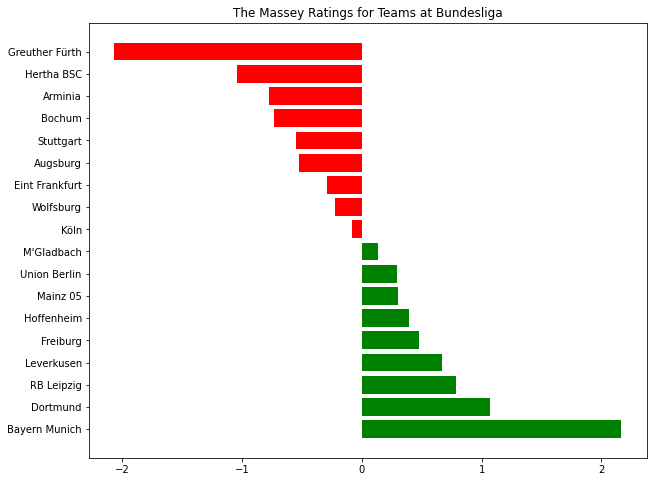

In [87]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
c = ['green' if data.value >= 0 else 'red' for i, data in results.iterrows()]
plt.barh(results.team, results.value, align='center', color=c)
plt.title('The Massey Ratings for Teams at Bundesliga')
fig.set_facecolor('white')
plt.show()